<a href="https://colab.research.google.com/github/ychhatre/ShoppingItemClassification/blob/main/ShoppingImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/vinay-swamy/deeplearning_tutorial/raw/main/data.tar.gz
!tar -xzf data.tar.gz
!ls data/ | head 

--2022-08-13 19:46:59--  https://github.com/vinay-swamy/deeplearning_tutorial/raw/main/data.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vinay-swamy/deeplearning_tutorial/main/data.tar.gz [following]
--2022-08-13 19:46:59--  https://raw.githubusercontent.com/vinay-swamy/deeplearning_tutorial/main/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29346211 (28M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  27.99M  --.-KB/s    in 0.08s   

2022-08-13 19:47:01 (329 MB/s) - ‘data.tar.gz’ saved [29346211/29346211]

0.png
10000

In [ ]:
!cd sample_data 
!ls
# !git init 
# !git config --global user.email "ychhatre@gmail.com"
# !git config --global user.name "Yash Chhatre"
# !git add .
# !git commit -m'initial commit'
# !git branch -M main
# !git remote add origin https://github.com/ychhatre/ShoppingItemClassification.git
# !git push -u origin main

data  data.tar.gz  sample_data


In [ ]:
import pandas as pd
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# pytorch imports 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

In [ ]:
class ShoppingItemDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.observations = pd.read_csv(csv_file) 
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
        return len(self.observations) 

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, str(self.observations.iloc[idx, 0])) + ".png"
    img = io.imread(img_path)
    label = torch.tensor(self.observations.iloc[idx, 1])

    if self.transform:
      img = self.transform(img)
    return img, label

# class NeuralNetwork(nn.Module): 
#   def __init__(self): 
#     super(NeuralNetwork, self).__init__()
#     self.fc1 = nn.Linear(784, 512)
#     self.fc2 = nn.Linear(512, 128) 
#     self.fc3 = nn.Linear(128, 10)
#   def forward(self, x): 
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = F.softmax(self.fc3(x), dim=1)
#     return x 
  

class ConvNetwork(nn.Module): 
  def __init__(self, isDropout): 
    super(ConvNetwork, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, 5)
    self.conv2 = nn.Conv2d(10, 20, 5) 
    self.conv3 = nn.Conv2d(20, 64, 3)
    self.pool = nn.MaxPool2d(2,2) 
    self.fc1 = nn.Linear(64, 32)
    self.fc2 = nn.Linear(32, 16) 
    self.fc3 = nn.Linear(16, 10)
    self.isDropout = isDropout
    if(isDropout):
      self.dropout = nn.Dropout(0.25)
  
  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) # [128, 10, 12, 12]
    x = self.pool(F.relu(self.conv2(x)))  # [128, 20, 4, 4]
    x = self.pool(F.relu(self.conv3(x))) # [128, 64, 1, 1]
    x = x.view(-1, 64)   
    x = F.relu(self.fc1(x))
    x = self.dropout(x) if self.isDropout else x 
    x = F.relu(self.fc2(x))
    x = self.dropout(x) if self.isDropout else x 
    x = F.softmax(self.fc3(x), dim=1)
    return x

class Trainer:
  def __init__(self, model, loss_function, optimizer, num_epochs, train_loader, val_loader, test_loader) -> None:
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer 
    self.num_epochs = num_epochs 
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader

  def train(self): # runs one epoch of training 
    losses = []
    for batch_idx, (data, targets) in enumerate(self.train_loader): 
      scores = self.model(data)
      loss = self.loss_function(scores, targets)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      losses.append(loss.item())
    return losses 

  def validation(self): 
    val_loss = []
    self.model.eval()
    for batch_idx, (data, targets) in enumerate(self.val_loader): 
      scores = self.model(data)
      loss = self.loss_function(scores, targets)
      val_loss.append(loss.item()) 
    return val_loss

  def training(self): 
    train_loss = []
    validation_loss = []
    for epoch in tqdm(range(self.num_epochs)): 
      loss = self.train()
      train_loss.append(np.mean(loss))
      
      val_loss = self.validation()
      validation_loss.append(np.mean(val_loss))

      print(f"epoch is {epoch} and train_loss is {train_loss[epoch]} and val_loss is {val_loss[epoch]}")
    return {"train_loss": train_loss, "val_loss": validation_loss}



  def check_accuracy(self, loader):
    correct = 0
    samples = 0
    self.model.eval()

    with torch.no_grad():
      for x,y in loader: 
        scores = self.model(x)
        _, predictions = scores.max(1)
        correct += (predictions == y).sum()
        samples += predictions.size(0)
      print(f'{correct}/{samples}')
    # self.model.train()
  
  def displayResults(self): 
    print("Training set: ")
    self.check_accuracy(self.train_loader)

    print("Test set: ")
    self.check_accuracy(self.test_loader)


epoch is 0 and train_loss is 2.142093220457863 and val_loss is 2.0407657623291016
epoch is 1 and train_loss is 1.9963698166246993 and val_loss is 1.969772219657898
epoch is 2 and train_loss is 1.9735655297105685 and val_loss is 1.9918627738952637
epoch is 3 and train_loss is 1.9628725600318786 and val_loss is 2.0349910259246826
epoch is 4 and train_loss is 1.9557525014724975 and val_loss is 1.9738162755966187
epoch is 5 and train_loss is 1.949113364417713 and val_loss is 1.9280991554260254
epoch is 6 and train_loss is 1.9430739155973489 and val_loss is 1.9309195280075073
epoch is 7 and train_loss is 1.9282862020376772 and val_loss is 1.910162329673767
epoch is 8 and train_loss is 1.9022633519035559 and val_loss is 1.8807040452957153
epoch is 9 and train_loss is 1.8921168357038651 and val_loss is 1.9460705518722534
Training set: 
23028/40000
Test set: 
5753/10000
epoch is 0 and train_loss is 2.0261660722878796 and val_loss is 1.8760676383972168
epoch is 1 and train_loss is 1.82453484466

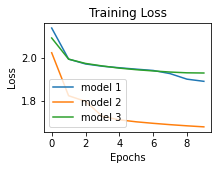

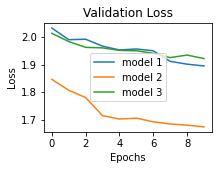

In [ ]:
models = [
    {"batch_size": 128, "learning_rate": 0.008, "model": ConvNetwork(isDropout=True), "dataset": ShoppingItemDataset(
      csv_file="data/image_labels.csv.gz", 
      root_dir="data", 
      transform=transforms.Compose(
          [
            transforms.ToTensor(), 
            transforms.RandomRotation(degrees=90),
            transforms.Resize(size=32)
          ]
      )
    )},
    {"batch_size": 128, "learning_rate": 0.008, "model": ConvNetwork(isDropout=True), "dataset": ShoppingItemDataset(
      csv_file="data/image_labels.csv.gz", 
      root_dir="data", 
      transform=transforms.Compose([transforms.ToTensor()]))
    }, 
    {"batch_size": 128, "learning_rate": 0.008, "model": ConvNetwork(isDropout=False), "dataset": ShoppingItemDataset(
      csv_file="data/image_labels.csv.gz", 
      root_dir="data", 
      transform=transforms.Compose(
          [
            transforms.ToTensor(), 
            transforms.RandomRotation(degrees=90),
            transforms.Resize(size=32)
          ]
      )
    )}, 
  ]


training_losses = []
val_losses = []
for i in range(len(models)):
  train_set, val_set, test_set, = torch.utils.data.random_split(models[i]["dataset"], [40000, 10000, 10000])
  trainer = Trainer( 
      model=models[i]["model"], 
      loss_function=nn.CrossEntropyLoss(), 
      optimizer=optim.Adagrad(models[i]["model"].parameters(), lr=models[i]["learning_rate"]), 
      num_epochs=10, 
      train_loader=DataLoader(train_set, models[i]["batch_size"], True), 
      test_loader=DataLoader(test_set, models[i]["batch_size"], True), 
      val_loader=DataLoader(val_set, models[i]["batch_size"], True))
  
  losses_map = trainer.training()
  training_losses.append(losses_map["train_loss"])
  val_losses.append(losses_map["val_loss"])
  trainer.displayResults()


def plot_loss(loss, isTraining): 
  plt.figure(figsize=(3, 2))
  plt.title("Training Loss" if isTraining else "Validation Loss")
  for i in range(len(loss)): 
    plt.plot(loss[i],label="model " + str(i + 1))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()          

plot_loss(training_losses, True)
plot_loss(val_losses, False)
